In [1]:
# Do the same using futures.

In [17]:
import math as mt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plot

class anoption:
    def __init__(self,T,K,sigma,r,call=True):
        self.T = T
        self.K = K
        self.call = call
        self.sigma = sigma
        self.r = r
    def price(self,t,S):
        tau = self.T.toordinal()-t.toordinal()
        tau = tau/365.0
        sigma = self.sigma
        r = self.r
        K = self.K
        ss = sigma*mt.sqrt(tau)
        d1 = 1/ss*(mt.log(S/K)+(r+sigma**2/2)*tau)
        d2 = d1 - ss
        self.d1 = d1
        self.d2 = d2
        PVK = K*mt.exp(-r*tau)
        if self.call:
            delta = st.norm.cdf(d1)
            self.delta = delta
            prob1 = delta
            prob2 = st.norm.cdf(d2)
            val2ret = prob1*S - prob2*PVK
        else:
            delta = st.norm.cdf(-d1)
            self.delta = -delta
            prob1 = st.norm.cdf(-d2)
            prob2 = delta
            val2ret = prob1*PVK - prob2*S 
        self.value = val2ret
        return val2ret
        
class underlying:
    def __init__(self,S0,t0,mu,sigma):
        self.S0 = S0
        self.t0 = t0
        self.mu = mu
        self.sigma = sigma
    def getret(self):
        ret = np.random.normal(self.mu/365,self.sigma/mt.sqrt(365),1)
        return float(ret)

class futures:
    def __init__(self,T,r):
        self.T = T
        self.r = r
    def price(self,t,S):
        tau = self.T.toordinal()-t.toordinal()
        tau = tau/365.0
        self.delta = mt.exp(self.r*tau)
        self.F = S*self.delta
        return(self.F)
    
class anaccount:
    def __init__(self,r,und,opt,fut,n_options,sfee,cash0):
        self.r = r
        self.und = und
        self.opt = opt
        self.fut = fut
        self.n_options = n_options
        self.fee_rate = sfee
        self.cash0 = cash0
        self.records = pd.DataFrame(columns=['Stk Prc','Fut Prc','Opt Prc','Fee','Fut N','Opt N','Fut Pos','Opt Pos','Cash no hedge','Total no hedge','Cash','Total'])
        self.addrecord()
    def addrecord(self): 
        nr, nc = np.shape(self.records)
        if nr == 0: 
            newdate = self.und.t0
            newprce = self.und.S0
        else:
            vakar = self.records.iloc[-1,]
            yesterday = vakar.name
            newdate = pd.Timestamp(1989,6,24)
            newdate = newdate.fromordinal(yesterday.toordinal()+1)
            yesterday_price = vakar['Stk Prc']
            newprce = yesterday_price*(1+self.und.getret())
        optval = self.opt.price(newdate,newprce)
        optN = self.n_options
        futprc = self.fut.price(newdate,newprce)
        futN = -self.opt.delta/self.fut.delta*optN
        optpos = optN*optval
        futpos = futN*futprc
        if nr == 0:
            cash_nh = self.cash0 - optpos
            cash = cash_nh
            if optpos < 0:
                thefee = -optpos*self.fee_rate
                cash = cash + thefee
                cash_nh = cash_nh + thefee
                price_to_quote = -optpos+thefee
        else:
   #         yesterday_stkN = vakar['Stk N']
   #         stk2buy = (stkN - yesterday_stkN)*newprce
            yesterday_F = vakar['Fut Prc']
            yesterday_futN = vakar['Fut N']
            cash2add = (futprc-yesterday_F)*yesterday_futN
            cash = vakar.Cash + cash2add
            cash_nh = vakar['Cash no hedge']
        total = optpos+cash
        total_nh = optpos+cash_nh
        if nr is 0 and optpos < 0:
            newrow = pd.Series(
                {'Stk Prc':newprce,
                 'Fut Prc':futprc,
                 'Opt Prc':optval,
                 'Fee': thefee,
                 'Fut N':futN,
                 'Opt N':optN,
                 'Fut Pos':futpos,
                 'Opt Pos':optpos,
                 'Cash':cash,
                 'Total':total,
                 'Cash no hedge':cash_nh,
                 'Total no hedge':total_nh},name = newdate)
        else:
            newrow = pd.Series(
                {'Stk Prc':newprce,
                 'Fut Prc':futprc,
                 'Opt Prc':optval,
                 'Fee': 0,
                 'Fut N':futN,
                 'Opt N':optN,
                 'Fut Pos':futpos,
                 'Opt Pos':optpos,
                 'Cash':cash,
                 'Total':total,
                 'Cash no hedge':cash_nh,
                 'Total no hedge':total_nh},name = newdate)
        self.records = self.records.append(newrow)
    def simulate(self,ndays,nruns):
        mintotal = 10**25
        for arun in range(nruns):
            self.records = pd.DataFrame(columns=['Stk Prc','Fut Prc','Opt Prc','Fut N','Opt N','Fut Pos','Opt Pos','Cash no hedge','Total no hedge','Cash','Total'])
            self.addrecord()          
            for i in range(ndays): self.addrecord()
            thismin = min(self.records.Total)
            mintotal = min(mintotal,thismin)
        return(mintotal)
        

In [31]:
all_records = []
variables = pd.DataFrame(columns = ['Mu', 'Sigma', 'K', 'T'])
mu = 0.05
sigma = 0.2
K = 50
T = pd.Timestamp(2019,8,31)
for i in range(1, 13):
    r = 0.05
    if i in range(4):
        mu += 0.05
    elif i in range(4, 7):
        sigma += 0.1
    elif i in range(7, 10):
        K += 50
    elif i in range(10, 13):
        month = i
        day = i*2
        T = pd.Timestamp(2019,month,day)
    variables.loc[i] = [mu, sigma, K, T]
    sfee = 0.20
    put1 = anoption(T,K,sigma,r,False)
    today = pd.Timestamp(2019,5,27)
    stk1 = underlying(K,today,mu,sigma)
    fut1 = futures(T,r)
    acc1 = anaccount(r,stk1,put1,fut1,-1,sfee,K*2)
    acc1.simulate(30,100)
    acc1.records.to_html('table'+str(i)+'.html')
    plot.plot(acc1.records['Total no hedge'])
    plot.plot(acc1.records['Total'])
    fname = 'fig'+str(i)+'.pdf'
    plot.savefig(fname)
    plot.clf()
variables.to_html('variables.html')

<Figure size 432x288 with 0 Axes>

In [10]:
all_records[0]

,Stk Prc,Fut Prc,Opt Prc,Fut N,Opt N,Fut Pos,Opt Pos,Cash no hedge,Total no hedge,Cash,Total,Fee
2019-05-27,50.000000,50.661877,2.730386,-0.429805,-1.0,-21.774731,-2.730386,103.276463,100.546077,103.276463,100.546077,0.546077
2019-05-28,48.359560,48.993009,3.503428,-0.515735,-1.0,-25.267432,-3.503428,103.276463,99.773035,103.993751,100.490323,0.000000
2019-05-29,48.124773,48.748469,3.616169,-0.529151,-1.0,-25.795284,-3.616169,103.276463,99.660295,104.119869,100.503700,0.000000
2019-05-30,48.500187,49.122019,3.406958,-0.509923,-1.0,-25.048428,-3.406958,103.276463,99.869505,103.922205,100.515246,0.000000
2019-05-31,49.342821,49.968611,2.978504,-0.465737,-1.0,-23.272241,-2.978504,103.276463,100.297959,103.490509,100.512004,0.000000
2019-06-01,49.219853,49.837256,3.024455,-0.472881,-1.0,-23.567110,-3.024455,103.276463,100.252008,103.551686,100.527231,0.000000
2019-06-02,48.961517,49.568888,3.137576,-0.487429,-1.0,-24.161329,-3.137576,103.276463,100.138887,103.678591,100.541015,0.000000
2019-06-03,47.922871,48.510712,3.668192,-0.545051,-1.0,-26.440834,-3.668192,103.276463,99.608272,104.194377,100.526186,0.000000
2019-06-04,48.272562,48.857999,3.466639,-0.526765,-1.0,-25.736676,-3.466639,103.276463,99.809824,104.005088,100.538449,0.000000
2019-06-05,47.085357,47.649869,4.128222,-0.593701,-1.0,-28.289777,-4.128222,103.276463,99.148241,104.641489,100.513267,0.000000


In [ ]:
all_records[1]

In [ ]:
all_records[2]

In [ ]:
all_records[3]

In [ ]:
all_records[4]

In [ ]:
all_records[5]

In [ ]:
all_records[6]

In [ ]:
all_records[7]

In [ ]:
all_records[8]

In [ ]:
all_records[9]

In [ ]:
all_records[10]

In [ ]:
all_records[11]

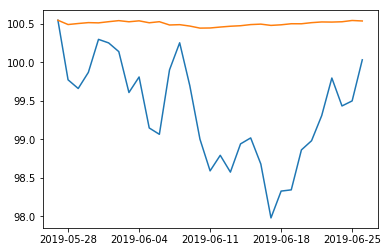

In [11]:
plot.plot(all_records[0]['Total no hedge'])
plot.plot(all_records[0]['Total'])
fname = 'fig'+str(i)+'.pdf'
plt.savefig(fname)
proc=subprocess.Popen(shlex.split('lpr {f}'.format(f=fname)))

<h3> Scratch work </h3>

In [6]:
np.random.RandomState(np.random.seed(1984))

In [7]:
np.random.randint(7, 12)

11

In [14]:
print(pd.Timestamp(2019, 6, 7))

2019-06-07 00:00:00


In [15]:
print(acc1.records)

              Stk Prc    Fut Prc   Opt Prc     Fut N  Opt N    Fut Pos  \
2019-05-27  50.000000  50.661877  2.730386 -0.429805   -1.0 -21.774731   
2019-05-28  48.359560  48.993009  3.503428 -0.515735   -1.0 -25.267432   
2019-05-29  48.124773  48.748469  3.616169 -0.529151   -1.0 -25.795284   
2019-05-30  48.500187  49.122019  3.406958 -0.509923   -1.0 -25.048428   
2019-05-31  49.342821  49.968611  2.978504 -0.465737   -1.0 -23.272241   
2019-06-01  49.219853  49.837256  3.024455 -0.472881   -1.0 -23.567110   
2019-06-02  48.961517  49.568888  3.137576 -0.487429   -1.0 -24.161329   
2019-06-03  47.922871  48.510712  3.668192 -0.545051   -1.0 -26.440834   
2019-06-04  48.272562  48.857999  3.466639 -0.526765   -1.0 -25.736676   
2019-06-05  47.085357  47.649869  4.128222 -0.593701   -1.0 -28.289777   
2019-06-06  46.931412  47.487572  4.210678 -0.603578   -1.0 -28.662468   
2019-06-07  48.377461  48.944053  3.374168 -0.523780   -1.0 -25.635897   
2019-06-08  49.039240  49.606786  3.02

In [16]:
pd.describe_option('display')
print(acc1.records)

display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]

display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]

display.column_space No description available.
    [default: 12] [currently: 12]

display.date_dayfirst : boolean
    When True, prints and parses dates with the day first, eg 20/01/2005
    [default: False] [currently: False]

display.date_yearfirst : boolean
    When True, prints and parses dates with the year first, eg 2005/01/20
    [default: False] [currently: False]

display.encoding : str/unicode
    Defaults to the detected encoding of the console.
    Specifies the encoding to be used for strings returned by to_string,
    these are generally strings meant to be displayed on the console.
    [default: UTF-8] 

In [24]:
plot.clf()

<Figure size 432x288 with 0 Axes>

In [25]:
plot.show()